In [4]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy import stats
from scipy import optimize
import pylab as pl
from fredapi import Fred

In [5]:
def get_data(stocks, start_date, end_date):
    stock_data = yf.download(stocks, start_date, end_date)
    stock_data = pd.DataFrame(stock_data)
    closing_prices = stock_data["Close"]
    log_returns = np.log(closing_prices.pct_change()+1)
    mean_of_returns = log_returns.mean()
    cov_of_returns = log_returns.cov()
    return log_returns , mean_of_returns, cov_of_returns



In [6]:
def portfolio_std(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [7]:
def expected_portfolio_returns(weigths, log_returns):
    return np.sum(log_returns.mean()*weigths)*100

In [8]:
def expected_mc_returns(weights, mean_returns, cov_mat, timeframe=100, sim_count=10000):
    mean_mat = np.full(shape =(timeframe, len(weights)), fill_value=mean_returns)
    mean_mat = mean_mat.T

    portfolio_sims = np.full(shape=(timeframe, sim_count),fill_value=0.0)
    initial_value = 10000

    for sim in range(0,sim_count):
        Z = np.random.normal(size=(timeframe,len(weights)))
        L = np.linalg.cholesky(cov_mat)
        daily_returns = mean_mat + np.inner(L,Z)

        portfolio_sims[:,sim] = np.cumprod(np.inner(weights, (np.exp(daily_returns)-1).T)+1)*initial_value

    expected = portfolio_sims[timeframe-1,:].mean()/initial_value
    return expected

def expected_mc_returns_reparametrized(weights, mean_returns, cov_mat, timeframe=100, sim_count=10000, Zs=None):
    mean_mat = np.full(shape =(timeframe, len(weights)), fill_value=mean_returns)
    mean_mat = mean_mat.T

    portfolio_sims = np.full(shape=(timeframe, sim_count),fill_value=0.0)
    initial_value = 10000

    for sim in range(0,sim_count):
        #Z = np.random.normal(size=(timeframe,len(weights))) # np.random.normal(size=(sim_count, timeframe,len(weights)))
        Z = Zs[sim]
        L = np.linalg.cholesky(cov_mat)
        daily_returns = mean_mat + np.inner(L,Z)

        portfolio_sims[:,sim] = np.cumprod(np.inner(weights, (np.exp(daily_returns)-1).T)+1)*initial_value

    expected = portfolio_sims[timeframe-1,:].mean()/initial_value
    return expected

In [16]:
def get_neg_sharpe(weights, log_returns,cov_mat, risk_free_rate):
    print(weights)
    # return -(expected_portfolio_returns(weights, log_returns)- (1+risk_free_rate))/portfolio_std(weights,cov_mat)

    portfolio_value = np.dot(log_returns.mean(), weights)
    return -(expected_mc_returns(weights, portfolio_value, cov_mat)- (1+risk_free_rate))/portfolio_std(weights,cov_mat)

def get_neg_sharpe_reparametrized(weights, log_returns,cov_mat, risk_free_rate, timeframe=100, sim_count=10000, Zs=None):
    #print(weights)
    #print("Zs: ", Zs)
    # return -(expected_portfolio_returns(weights, log_returns)- (1+risk_free_rate))/portfolio_std(weights,cov_mat)

    portfolio_value = np.dot(log_returns.mean(), weights)
    return -(expected_mc_returns_reparametrized(weights, portfolio_value, cov_mat, timeframe=timeframe, sim_count=sim_count, Zs=Zs)- (1+risk_free_rate))/portfolio_std(weights,cov_mat)

In [10]:

stock_names = ["AAPL", "TSLA", "AMZN", "GOOG"]
stocks = [stock for stock in stock_names]
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=400)

log_returns, mean_returns, cov_returns = get_data(stocks, start_date, end_date)
print(log_returns.shape)
print(mean_returns.shape)
#weighted_mean_returns = np.dot(log_returns, weights)


[*********************100%%**********************]  4 of 4 completed
(274, 4)
(4,)


In [11]:
fred = Fred(api_key="f3fea224d98377beff02b72fbe0cb196")
ten_yr_tres_rate = fred.get_series_latest_release("GS10")/100

risk_free_rate = ten_yr_tres_rate.iloc[-1]

In [22]:
weights = np.ones(len(mean_returns))
#weights = np.sum(weights)
annual_cov_mat = cov_returns*100

portfolio_value = np.dot(mean_returns, weights)

constraints = {"type": "eq", "fun": lambda weights : np.sum(weights)- 1}
bounds = [(0,0.5) for stock in range(len(stock_names))]
sim_count=10000
timeframe=100
Zs = np.random.normal(size=(sim_count, timeframe, weights.size))
print(stock_names)
print("Zs shape: ", Zs.shape)
print("mean returns:", mean_returns)
print("portfolio value:", portfolio_value)

optimized_weights = optimize.minimize(get_neg_sharpe, weights, args=(log_returns, annual_cov_mat,risk_free_rate), method = "SLSQP", constraints=constraints, bounds=bounds)
optimized_weights_reparamed = optimize.minimize(get_neg_sharpe_reparametrized, weights, args=(log_returns, annual_cov_mat,risk_free_rate, timeframe, sim_count, Zs), method = "SLSQP", constraints=constraints, bounds=bounds)
weights  = np.array(optimized_weights["x"])
weights_reparamed = np.array(optimized_weights_reparamed["x"])
value_reparamed = np.array(optimized_weights_reparamed)
print(weights.shape)
print(weights)
print("reparamed:", weights_reparamed)
print("reparamed_val:", value_reparamed)


['AAPL', 'TSLA', 'AMZN', 'GOOG']
Zs shape:  (10000, 100, 4)
mean returns: AAPL    0.000984
AMZN    0.001855
GOOG    0.001459
TSLA    0.001496
dtype: float64
portfolio value: 0.005793429291102044
[0.5 0.5 0.5 0.5]
[0.49999999 0.5        0.5        0.5       ]
[0.5        0.49999999 0.5        0.5       ]
[0.5        0.5        0.49999999 0.5       ]
[0.5        0.5        0.5        0.49999999]
[0.5 0.5 0.5 0.5]
Zs:  [[[-0.80932925 -0.38491357 -0.66867331 -1.18575548]
  [ 0.29359159 -0.8138611   0.251688   -2.27615585]
  [-0.61159166  1.46271386 -1.2146579  -0.66548337]
  ...
  [-0.1445056  -1.72630557 -0.37920011 -0.77593259]
  [ 2.7619848   0.36119999 -0.17230068  1.83226478]
  [-1.06375027  0.81445929  0.11981283  0.797536  ]]

 [[-1.39194649 -1.38338003  0.64441784 -0.72567957]
  [-0.66408942  0.93049567  0.61637641 -1.96093239]
  [-0.91677982 -0.57381365 -1.51598542 -1.016657  ]
  ...
  [ 0.61525181  2.56927768 -0.46403074 -1.67627963]
  [ 1.96953855 -1.01349244  0.56795585 -0.8173

Text(0.5, 1.0, 'Monte Carlo sim of Portfolio')

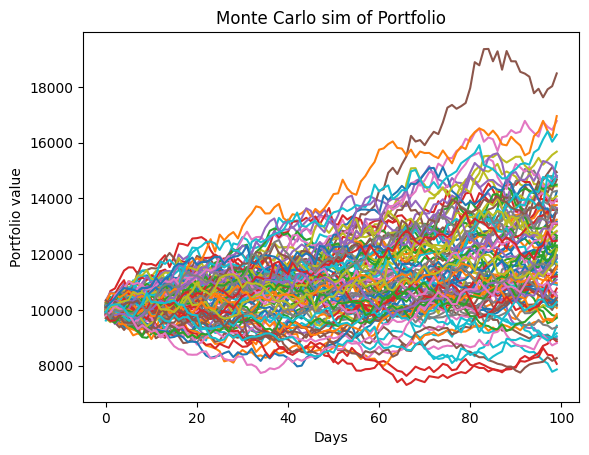

In [ ]:
sim_count = 10000
timeframe = 100
mean_mat = np.full(shape =(timeframe, len(weights)), fill_value=mean_returns)
mean_mat = mean_mat.T

portfolio_sims = np.full(shape=(timeframe, sim_count),fill_value=0.0)
initial_value = 10000

for sim in range(0,sim_count):
    Z = np.random.normal(size=(timeframe,len(weights)))
    L = np.linalg.cholesky(cov_returns)
    daily_returns = mean_mat + np.inner(L,Z)

    portfolio_sims[:,sim] = np.cumprod(np.inner(weights, (np.exp(daily_returns)-1).T)+1)*initial_value


plt.plot(portfolio_sims[:,0:100])
# print(portfolio_sims)
plt.ylabel("Portfolio value")
plt.xlabel("Days")
plt.title("Monte Carlo sim of Portfolio")

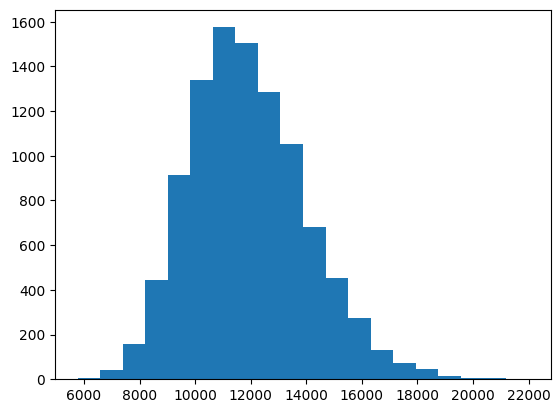

In [ ]:
#analyze probability of a specific value
day = timeframe-1
values = portfolio_sims[day,:]

# fit = stats.norm.pdf(values, np.mean(values), np.std(values))

plt.hist(values, bins=20)
plt.show()

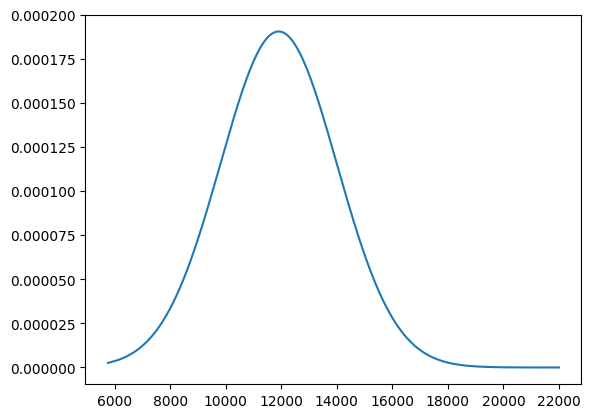

In [ ]:
pdf = stats.norm.pdf(np.sort(values), np.mean(values), np.std(values))
plt.plot(np.sort(values), pdf)

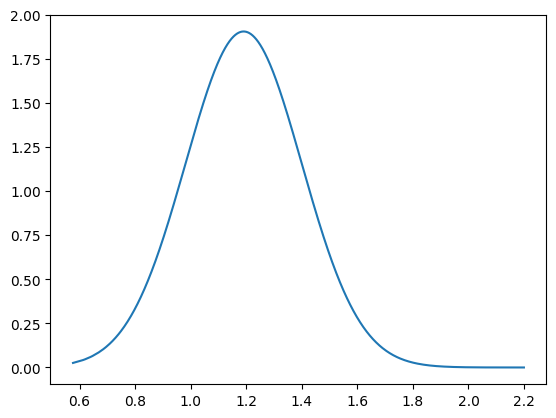

In [ ]:
return_rates = values/initial_value
pdf2 = stats.norm.pdf(np.sort(return_rates), np.mean(return_rates), np.std(return_rates))
plt.plot(np.sort(return_rates), pdf2)



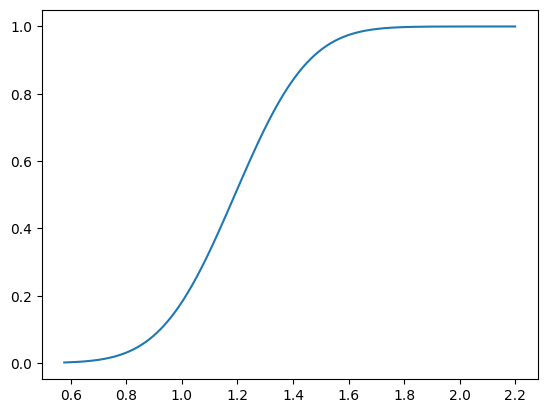

1.4695085025717682
1.4590255203356504


In [ ]:
norm_cdf = stats.norm.cdf(np.sort(return_rates),np.mean(return_rates), np.std(return_rates))
sns.lineplot(x=np.sort(return_rates), y=norm_cdf)
plt.show()
print(np.percentile(return_rates,90))
print(stats.norm.ppf(0.9, np.mean(return_rates), np.std(return_rates)))

In [ ]:
print((return_rates.mean()- (risk_free_rate+1))/portfolio_std(weights, cov_returns))

8.325997651294681
